In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# warfarin data import
wd = pd.read_csv('../warfarin_data.csv', header=None)

In [3]:
# format data
X = wd.to_numpy()
# correct dosage bucket (arm)
y = X[:,-2]
# correct dosage exact amount (continuous var)
y_val = X[:,-1]
# features
X = X[:,:-2]
N = X.shape[0]
#X = np.concatenate((np.ones((N,1)),X),axis=1)
k = X.shape[1]

# number of arms
arms = np.unique(y).astype(int)
n_arms = arms.shape[0]

# standardize X
X = (X - X.mean(axis=0))/X.std(axis=0)
xbar = X.mean(axis=0)

In [4]:
def make_col_vec(x):
    N = x.shape[0]
    return x.reshape((N,1))

# 0-1 Loss
def loss01(y_pull, y_true):
    return (y_pull == y_true)*(-1.) + 1

In [5]:
# empirical losses
yloss = np.zeros((N,n_arms))
for y_pull in arms:
    yloss[:,y_pull] = loss01(y_pull,y)

In [6]:
# linear arm priors
mu = 1 - (-1*yloss + 1).sum(axis=0)/len(yloss)
# additional Bayesian parameters
rho2 =.5 # strictness of prior
s2 = .0001 # variance of errors
p = 1 # precision (1/variance) of prior betas

In [7]:
# Gaussian posterior and sampling
def hard_post(Omega, nu, s2, xbar, mu, y, x):
    Omega_tilde = Omega + np.outer(x - xbar, x - xbar)/s2
    nu_tilde = np.linalg.inv(Omega_tilde) @ (Omega @ nu - (y - mu)/s2 * (x-xbar))
    return [Omega_tilde, nu_tilde]

def soft_post(Omega, nu, s2, y, x):
    x = np.concatenate([np.array([1]),x])
    Omega_tilde = Omega + np.outer(x,x)/s2
    nu_tilde = np.linalg.inv(Omega_tilde) @ (Omega @ nu - y/s2 * x)
    return [Omega_tilde, nu_tilde]  

def post(Omega, nu, s2, xbar, mu, y, x, soft=True):
    if soft:
        return soft_post(Omega, nu, s2, y, x)
    else:
        return hard_post(Omega, nu, s2, xbar, mu, y, x)

def draw_norm(Omega, nu):
    cOi = np.linalg.inv(np.linalg.cholesky(Omega))
    return nu + cOi @ np.random.normal(size=Omega.shape[0])

In [8]:
# initial priors
Omega0_hard = p*np.eye(k)
nu0_hard = np.zeros((k,))
OmegaH = [Omega0_hard for i in range(n_arms)]
nuH = [nu0_hard for i in range(n_arms)]

Omega0_soft = np.concatenate(
    [make_col_vec(np.concatenate(
        [np.array([xbar @ Omega0_hard @ xbar + rho2]), Omega0_hard @ xbar])),
    np.concatenate(
        [make_col_vec(Omega0_hard @ xbar).T, Omega0_hard], axis=0)],
    axis=1)
OmegaS = [Omega0_soft for i in range(n_arms)]
nuS = [np.concatenate([np.array([xbar @ nu0_hard - mu[i]]), nu0_hard])
             for i in range(n_arms)]

Omega0_vanilla = p*np.eye(k+1)
nu0_vanilla = np.zeros((k+1,))
OmegaV = [Omega0_vanilla for i in range(n_arms)]
nuV = [nu0_vanilla for i in range(n_arms)]

In [9]:
def Thompson(y, x, Omega, nu, xbar, mu, n_arms, soft=True):
    betas = [draw_norm(Omega[i],nu[i]) for i in range(n_arms)]
    if soft:
        fits = [betas[i][0] + np.dot(x,betas[i][1:]) for i in range(n_arms)]
    else:
        beta0s = [mu[i] - np.dot(xbar, betas[i]) for i in range(n_arms)]
        fits = [beta0s[i] + np.dot(x, betas[i]) for i in range(n_arms)]
    arm = np.argmin(fits)
    regret = y[arm]
    return [arm, regret]

In [22]:
draw_norm(OmegaS[0], nuS[0])

array([-6.64734513e-01, -1.76023317e-04,  8.52730263e-02, -3.33331791e-03,
        1.08057657e-02,  9.02482624e-02, -2.72795649e-02,  1.82789832e-03,
       -4.85461220e-02, -6.40615841e-02, -6.38475125e-02, -2.52206418e-02,
       -4.50232291e-02,  7.99825667e-03, -6.51696794e-03, -2.83923045e-02,
       -1.62819845e-02, -3.44979681e-02,  6.41024888e-03, -2.95801506e-02,
        6.10390831e-03,  9.08935067e-03,  8.33339303e-03,  1.54075660e-02,
        3.92997639e-02,  2.35678725e-03,  2.67432423e-02, -8.66847705e-04,
        8.47926710e-04,  4.20050943e-02, -2.20090753e-02, -3.37898519e-02,
        3.09673675e-02,  2.19998484e-02, -6.89396335e-02, -2.24683885e-02,
       -7.55742380e-03,  5.89133617e-02,  1.28261725e-02,  1.45866684e-02,
        2.05091955e-03,  5.45287838e-04,  5.35705322e-03, -1.04874751e-01,
        6.33023913e-03,  6.71833701e-02,  1.13176547e-02, -2.34201563e-01,
        9.51857884e-03,  1.67673671e-01,  4.10817555e-03,  2.61587692e-02,
        2.49389888e-03, -

In [11]:
ss = 500
aa = np.zeros((ss,))
for i in range(ss):
    aa[i] = Thompson(yloss[0,:],xbar,OmegaH, nuH, xbar, mu, n_arms, soft=False)[0]
print((aa==0).sum()/ss)
print((aa==1).sum()/ss)
print((aa==2).sum()/ss)

[nuS[0][0], nuS[1][0], nuS[2][0]]

0.0
1.0
0.0


[-0.6680535455861071, -0.4587554269175108, -0.8731910274963821]

In [12]:
def RunThompson(y, X, Omega, nu, s2, xbar, mu, n_arms, soft=True):
    N = X.shape[0]
    r = np.zeros((N,2)) # results vector
    for i in range(N):
        [arm, regret] = Thompson(y[i,:], X[i,:],
                               Omega, nu, xbar, mu, n_arms, soft=soft)
        [Omega[arm], nu[arm]] = post(Omega[arm], nu[arm], s2, xbar,
                                     mu[arm], y[i,arm], X[i,:], soft=soft)
        r[i,:] = [arm, regret]
    return r

In [13]:
def shuffle(N, replace=False):
    idx = np.random.choice(N, size=(N,), replace=replace)
    return idx

In [14]:
nsim = 1
res_hard = []
res_vanilla = []
res_soft = []
best_arm = []
for i in range(nsim):
    idx = shuffle(N)
    res_hard.append(RunThompson(yloss[idx,:], X[idx,:], OmegaH, nuH, s2,
                           xbar, mu, n_arms, soft=False))
    res_vanilla.append(RunThompson(yloss[idx,:], X[idx,:], OmegaV, nuV, s2,
                              xbar, mu, n_arms, soft=True))
    res_soft.append(RunThompson(yloss[idx,:], X[idx,:], OmegaS, nuS, s2,
                           xbar, mu, n_arms, soft=True))
    best_arm.append(yloss[idx,:].argmin(axis=1))

In [15]:
def make_frame(res, i, label='none'):
    x = pd.DataFrame(res_hard[i])
    x.reset_index(inplace=True)
    x.columns = ['Iteration','Decision','Regret']
    x['Best'] = best_arm[i]
    x['Cumulative Regret'] = x['Regret'].cumsum()
    x['Frac Regret'] = x['Cumulative Regret']/(1+x['Iteration'])
    x['Permutation'] = i
    x['Bandit'] = label
    x = x[['Permutation','Bandit','Iteration','Decision','Best','Regret','Cumulative Regret','Frac Regret']]
    return x

In [16]:
th = pd.concat([make_frame(res_hard, i, label='Thompson Hard') for i in range(nsim)])
ts = pd.concat([make_frame(res_soft, i, label='Thompson Soft') for i in range(nsim)])
tv = pd.concat([make_frame(res_vanilla, i, label='Thompson Vanilla') for i in range(nsim)])

In [17]:
def thompsonagg(t):
    tagg = t.groupby('Iteration')['Frac Regret'].agg(
        ['mean',lambda x: np.quantile(x,.025),lambda x: np.quantile(x,.975)]).reset_index()
    tagg.columns = ['Iteration','Avg','Lower','Upper']
    return tagg

In [18]:
thagg = thompsonagg(th)
tsagg = thompsonagg(ts)
tvagg = thompsonagg(tv)

In [19]:
def thompsonplot(t, label):
    plt.plot(t['Iteration'],t['Avg'], label=label)
    plt.fill_between(t['Iteration'],t['Lower'],t['Upper'])

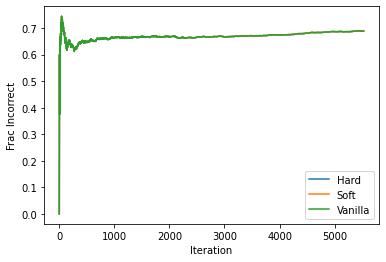

In [23]:
thompsonplot(thagg, 'Hard')
thompsonplot(tsagg, 'Soft')
thompsonplot(tvagg, 'Vanilla')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Frac Incorrect')
plt.savefig('thompson.png')
plt.show()

In [21]:
th.head(30)

,Permutation,Bandit,Iteration,Decision,Best,Regret,Cumulative Regret,Frac Regret
0,0,Thompson Hard,0,1.0,1,0.0,0.0,0.000000
1,0,Thompson Hard,1,0.0,1,1.0,1.0,0.500000
2,0,Thompson Hard,2,1.0,1,0.0,1.0,0.333333
3,0,Thompson Hard,3,0.0,1,1.0,2.0,0.500000
4,0,Thompson Hard,4,1.0,0,1.0,3.0,0.600000
5,0,Thompson Hard,5,1.0,1,0.0,3.0,0.500000
6,0,Thompson Hard,6,1.0,1,0.0,3.0,0.428571
7,0,Thompson Hard,7,1.0,1,0.0,3.0,0.375000
8,0,Thompson Hard,8,0.0,1,1.0,4.0,0.444444
9,0,Thompson Hard,9,0.0,1,1.0,5.0,0.500000
